In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
from reco_systems.filter import filter_df
from reco_systems.CF_knn import calc_similarity_matrix, get_KNN
from reco_systems.user_game_matrix import get_matrix_user_game

In [53]:
# import DB et set min_reviews
folder = "database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"trictrac_database/users.csv", names=["Username", "User id"])



# Global vision on users distances distribution [sample = 5 users]

In [54]:
# Filter for min_reviews for users & games
min_reviews = 5
rev_filter = filter_df(avis_clean, min_reviews)

11201 10549
3242 3957
3006 3910
3003 3910


In [56]:
matrix_ratings, mask_ratings, users_table, games_table = get_matrix_user_game(rev_filter)
# cos_sim_matrix, _ = calc_similarity_matrix(matrix_ratings, mask_ratings, "cos")
# cos_sim_matrix
cos_sim_matrix = np.load("generated_data/cos_sim_matrix_min5.npy")

Division of users by reviews
1. plus que 400
2. entre 100 et 400
3. de 6 à 100

In [58]:
# Find users (5) for who we will plot distances. Create dataframe : User index (in matrix), User id (in DB), Count reviews (per user)

# Case 1 : top 5 most active
#users_ids = rev_filter[["User id", "Game id"]].groupby("User id", as_index=True).count().sort_values("Game id", ascending=False).head(5) 

# Case 2 : random sample for users in a category 
users_ids = rev_filter[["User id", "Game id"]].groupby("User id", as_index=True).count()
users_ids = users_ids[(users_ids["Game id"] >= 6) & (users_ids["Game id"] < 100)].sample(5)

assoc = users_table.to_frame().merge(users_ids, left_on="User id", right_index=True).reset_index()
assoc.columns = ["User index", "User id", "Count reviews"]
user_indices = assoc["User index"].to_numpy()

users_ids

,Game id
User id,
910,16
863,99
2395,76
1048,9
3851,65


In [ ]:
# Avoid taking distance to user himself (located at the matrix diagonal)
users_dist = np.array([np.delete(cos_sim_matrix[user], user) for user in user_indices]) 
users_dist.shape

(5, 3002)

In [66]:
user_distances = np.round(users_dist, 2)   # eliminate distance precision 
dist_for_df  = user_distances.ravel()          # N-D to 1-D array
users_for_df = np.repeat(user_indices, 3002) # repeat each user's index k times (to construct dataframe in the next cell)
users_for_df.shape, dist_for_df.shape

((15010,), (15010,))

In [67]:
# Constuct Dataframe : where to each user index we associate an array of distances to ALL other users (except user himself)
# Dataframe is in the form (example for user index = 0)
# User index | Distance
# 0          | d1 (to user 1)
# 0          | d2 (to user 2)
# 0          | d3 (to user 3)

distance_to_users = pd.DataFrame({"Distance": dist_for_df, "User index":users_for_df}).sort_values("Distance")
distance_to_users = distance_to_users.groupby(["Distance", "User index"], as_index=True).size().reset_index(name="Number of users")
distance_to_users

,Distance,User index,Number of users
0,0.24,1800,1
1,0.58,538,1
2,0.68,538,1
3,0.69,538,1
4,0.70,538,1
...,...,...,...
124,1.00,459,2708
125,1.00,484,2787
126,1.00,538,1902
127,1.00,1124,2682


/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_7938/4119155826.py:3: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  ax = sns.pointplot(distance_to_users, x="Distance", y="Number of users", hue="User index", scale=0.5,  palette="Spectral")


Text(0.5, 0.98, '5 users [6 - 100 reviews]')

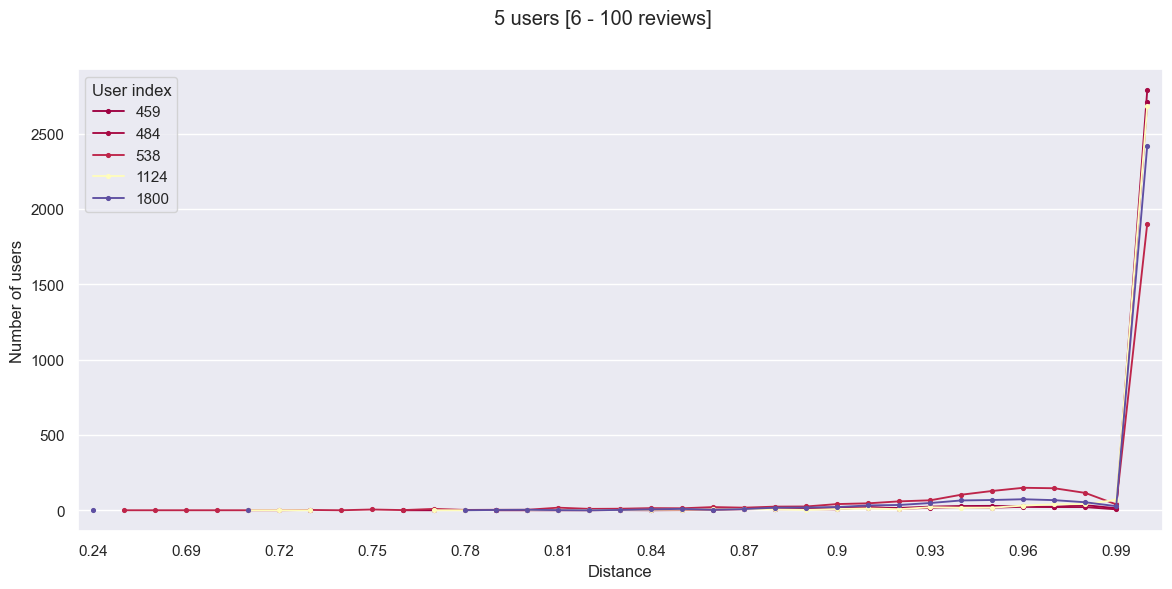

In [ ]:
sns.set_theme(rc={'figure.figsize':(14,6)})

ax = sns.pointplot(distance_to_users, x="Distance", y="Number of users", hue="User index", scale=0.5,  palette="Spectral")

for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 3 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
ax.figure.suptitle("5 users [6 - 100 reviews]")
# g = sns.FacetGrid(distance_to_users, col="User index", col_wrap=4, xlim=(0.4, 1.))
# g.map(sns.scatterplot, "Distance", "Number of users")
# g.figure.subplots_adjust(top=0.9) 
# g.figure.suptitle("Users [100-420 reviews]. k = 54 cos")